In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import numpy as np
import time

from state_of_the_artefact.representation import generate_midi_data, create_ctable
from state_of_the_artefact.utilities import reverse_sequences

In [40]:
TIMESTEPS = 8
BATCH_SIZE = 32
NUM_BATCHES = 300

In [41]:
characters = [f"{i}" for i in range(21, 36)]
encode, decode, vectorize = create_ctable(characters)

dataset = vectorize(generate_midi_data(NUM_BATCHES * BATCH_SIZE, TIMESTEPS, midi_numbers=range(21, 36)))
reversed_dataset =  reverse_sequences(dataset)
train_dataset = tf.data.Dataset.from_tensor_slices((reversed_dataset, dataset)).shuffle(len(dataset)).batch(BATCH_SIZE)

print(dataset.shape, reversed_dataset.shape)

(9600, 8, 15) (9600, 8, 15)


In [45]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)


@tf.function
def monte_carlo_estimation(x_logit, x, z_mean, z_logvar, z):
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, z_mean, z_logvar)
    
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def kl_loss(z_mean, z_logvar):
    return -0.5 * tf.reduce_mean(1 + z_logvar - tf.square(z_mean) - tf.exp(z_logvar))


class RVAE(tf.keras.Model):
    def __init__(self, timesteps, input_dim, hidden_dim, latent_dim, name="RVAE", **kwargs):
        super(RVAE, self).__init__(name=name, **kwargs)

        self.inference_net = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(timesteps, input_dim)),
            tf.keras.layers.LSTM(hidden_dim, return_sequences=True, name="hidden"),
            tf.keras.layers.LSTM(latent_dim + latent_dim, name="latent_mean_logvar")
        ], name="inference_net") 

        self.generator_net = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.RepeatVector(timesteps, name="repeat"),
            tf.keras.layers.LSTM(hidden_dim, return_sequences=True, name="hidden"),
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(input_dim), name="collector")
        ], name="generator_net")

        self.elbo = tf.keras.metrics.Mean(name="elbo")
        self.kl_loss = tf.keras.metrics.Mean(name="kl_loss")
    
    def encode(self, x):
        z_mean, z_logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
        return z_mean, z_logvar
    
    def decode(self, z, apply_activation=False):
        logits = self.generator_net(z)
        if apply_activation:
            return tf.nn.sigmoid(logits)
        return logits

    def reparameterize(self, z_mean, z_logvar):
        eps = tf.random.normal(shape=tf.shape(z_mean))
        return eps * tf.exp(z_logvar * .5) + z_mean

    def compile(self, optimizer='adam', loss=None, **kwargs):
        super(RVAE, self).compile(optimizer=optimizer, **kwargs)
        self.loss_fn = loss

    def call(self, x):
        z_mean, z_logvar = self.encode(x)
        z = self.reparameterize(z_mean, z_logvar)
        reconstructed = self.decode(z)
        return reconstructed

    @tf.function
    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            z_mean, z_logvar = self.encode(x)
            z = self.reparameterize(z_mean, z_logvar)
            x_logits = self.decode(z)

            ELBO = self.loss_fn(x_logits, y, z_mean, z_logvar, z)
            KL = kl_loss(z_mean, z_logvar)  # This is incorporated in the ELBO, this is for the metrics.
        
        gradients = tape.gradient(ELBO, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self.elbo.update_state(ELBO)
        self.kl_loss.update_state(KL)

        return {'elbo': -self.elbo.result(), 'kl_loss': self.kl_loss.result()}

    def summarize(self):
        self.inference_net.summary()
        self.generator_net.summary()

In [46]:
cs = RVAE(TIMESTEPS, len(characters), 128, 32)
cs.compile(optimizer=tf.keras.optimizers.Adam(), loss=monte_carlo_estimation)

In [47]:
hist = cs.fit(train_dataset, epochs=20, batch_size=BATCH_SIZE)

Epoch 1/20
300/300 [==============================] - 4s 13ms/step - elbo: -37.9280 - kl_loss: 0.0864
Epoch 2/20
300/300 [==============================] - 4s 12ms/step - elbo: -31.6484 - kl_loss: 0.0422
Epoch 3/20
300/300 [==============================] - 4s 14ms/step - elbo: -30.3676 - kl_loss: 0.0117
Epoch 4/20
300/300 [==============================] - 4s 14ms/step - elbo: -29.6223 - kl_loss: 6.9924e-04
Epoch 5/20
300/300 [==============================] - 4s 14ms/step - elbo: -29.4476 - kl_loss: 2.3238e-05
Epoch 6/20
300/300 [==============================] - 4s 14ms/step - elbo: -29.4325 - kl_loss: 1.2475e-05
Epoch 7/20
300/300 [==============================] - 4s 14ms/step - elbo: -29.4278 - kl_loss: 4.8159e-06
Epoch 8/20
300/300 [==============================] - 4s 15ms/step - elbo: -29.4220 - kl_loss: 5.7894e-06
Epoch 9/20
300/300 [==============================] - 4s 15ms/step - elbo: -29.4224 - kl_loss: 5.9043e-06
Epoch 10/20
300/300 [==============================] - 4s 

In [24]:
m, l = cs.encode(reversed_dataset)
z = cs.reparameterize(m, l)
reconstructions = cs.decode(z, True).numpy()

missclassifieds = 0
for original, reconstruction in zip(dataset, reconstructions):
    a = np.argmax(original, axis=1)
    b = np.argmax(np.rint(reconstruction), axis=1)

    if not np.array_equiv(a, b):  
        missclassifieds += 1
    else:
        print(a)
        print(b)

print(missclassifieds)
print(reconstructions.shape)

38400
(38400, 16, 15)


In [48]:
selected_x = reversed_dataset[:16:2]

m, l = cs.encode(selected_x)
z = cs.reparameterize(m, l)
reconstructions = cs.decode(z, True).numpy()

for original, reconstruction in zip(selected_x, reconstructions):
    a = np.argmax(original, axis=1)
    b = np.argmax(reconstruction, axis=1)

    print("a:", a)
    print("b:", b)

[11  0  4  8  0  6  2  3]
[11 11  6  6  6  6  6  6]
[ 9 14 12 11  8  8  3  1]
[8 1 1 1 1 1 1 1]
[ 2  4  7  4 10 13 10  5]
[8 1 5 5 6 6 6 6]
[12  2 10 14  4  5  3  8]
[8 1 1 1 6 6 6 6]
[ 8  4  5  6 12 12 10 11]
[ 1 11  1  1  1  6  6  6]
[10  1  7  2  1  3 11 13]
[5 1 1 1 1 1 1 1]
[11  4  7  5  9 13  8 11]
[5 1 6 6 6 6 6 6]
[13 13  1  1  8 14  1  2]
[10 13 13 13  6  7  7  7]


[[ 0  0  0  5 13  9  4  2  0  0  6  0  8  0  1]
 [14  1  0  0  8  0  7  4 12  0 15  5  0  2  0]
 [ 0  7  0  1  2  0  6 12  0 14  3  0  9  0 10]
 [ 8 12  0  0  0  4 11  1  3  0  0  9  0  0  5]]


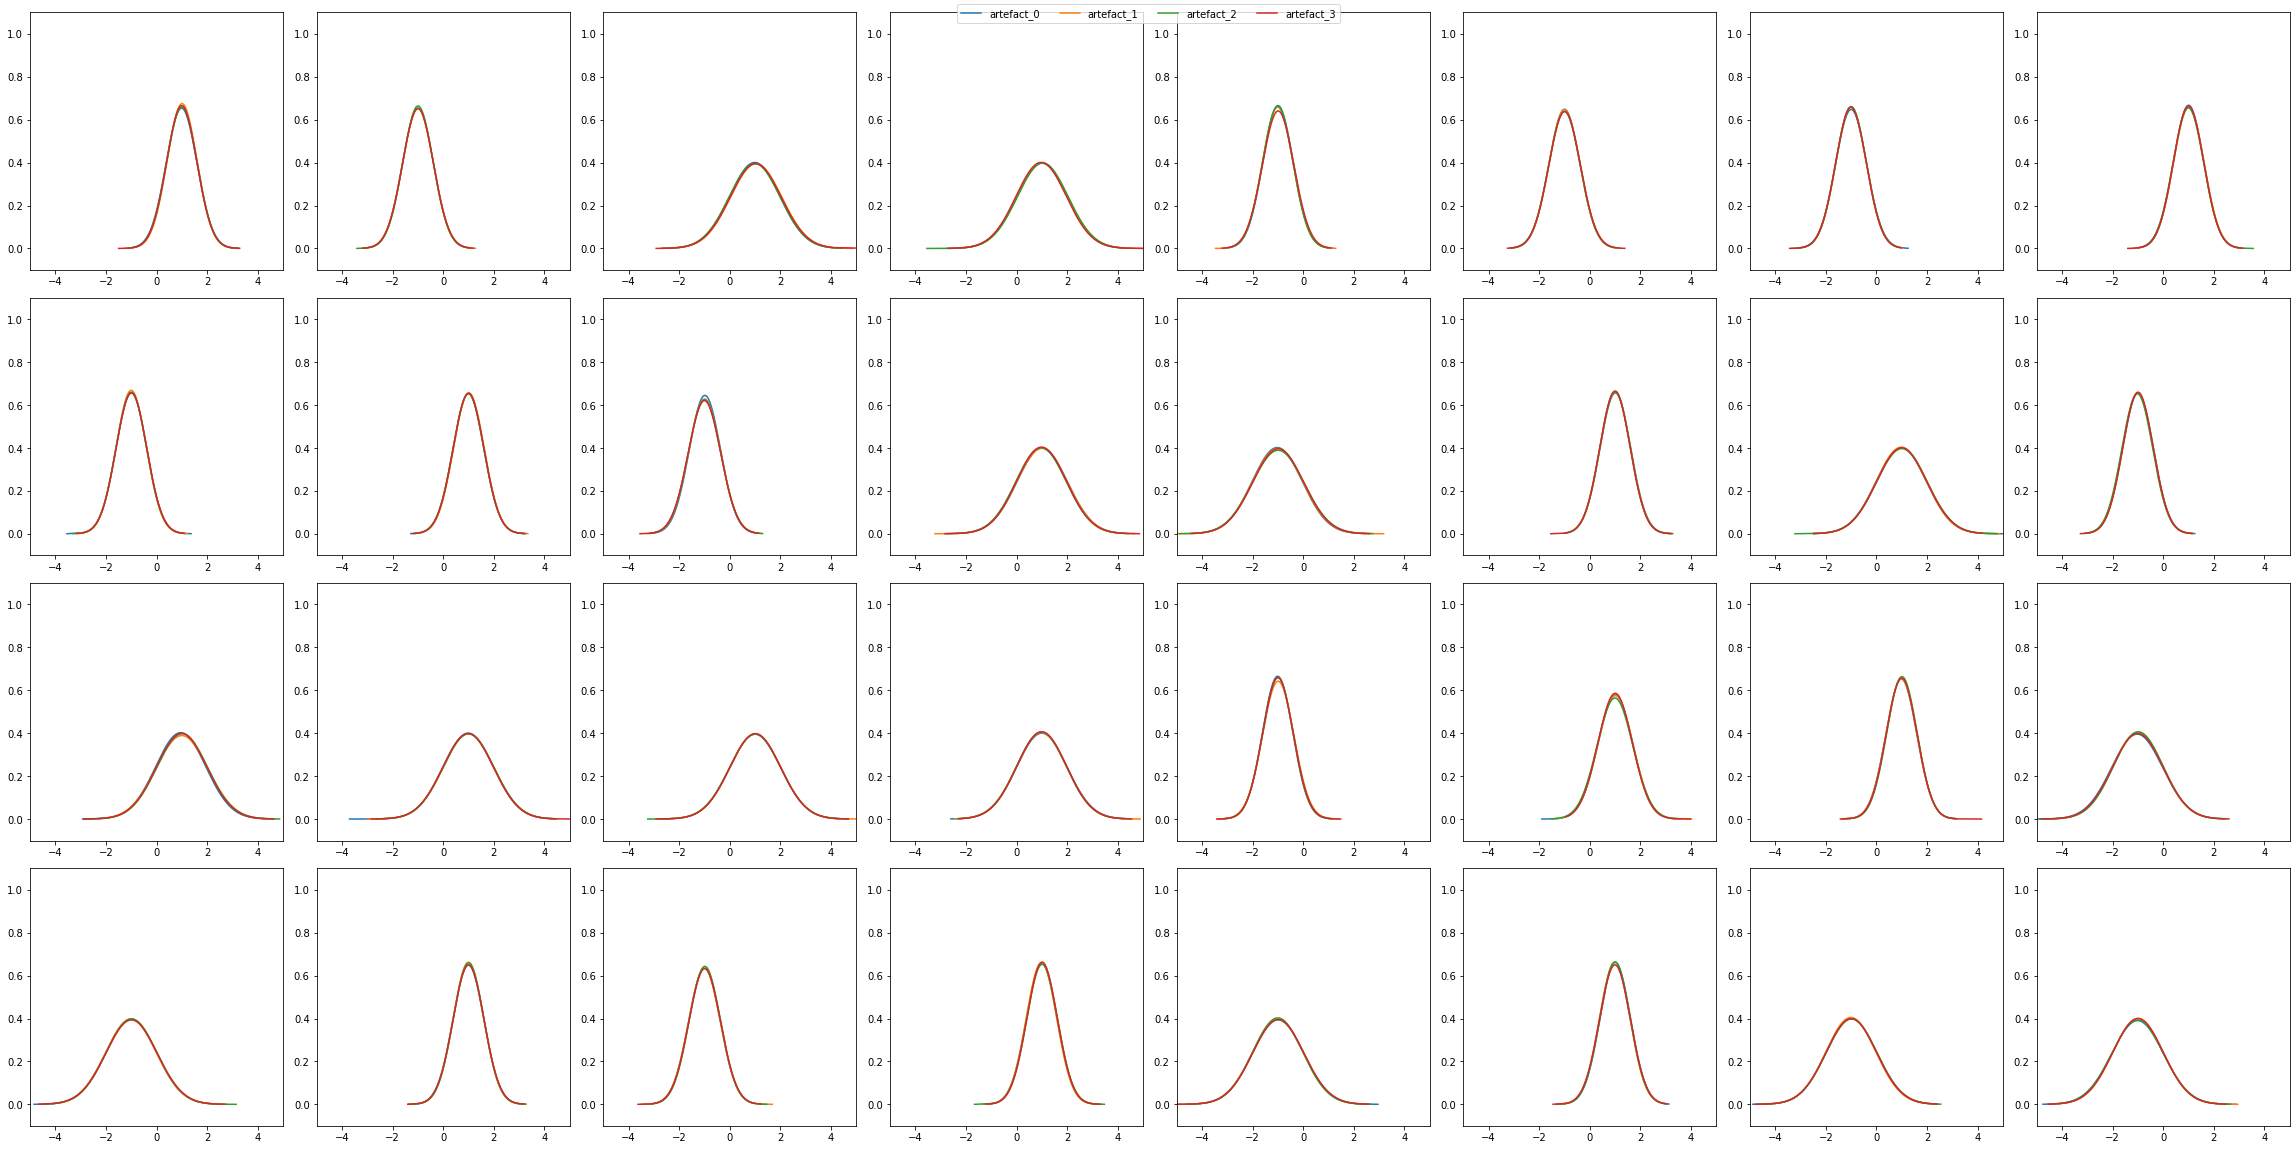

In [29]:
from scipy.stats import norm
import matplotlib.pyplot as plt

selected_x = reversed_dataset[:8:2]
print(np.argmax(selected_x, axis=1))
z_mean, z_logvar = cs.encode(selected_x)



fig, axs = plt.subplots(4, 8, figsize=(4 * 8, 4 * 4))
labels = [f"artefact_{i}" for i in range(0, len(selected_x))]

for i, ax in enumerate(axs.flatten()):

    for j in range(0, len(selected_x)):
        std = np.exp(0.5 * z_logvar[j][i]) # make the plots a bit saner
        h = sorted(np.random.normal(z_mean[j][i], std, 5000))
        pdf = norm.pdf(h, np.mean(h), np.std(h))
        ax.plot(h, pdf, label=labels[j])   
    
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlim(-5, 5)

fig.legend(loc="upper center", labels=labels, ncol=32)
plt.tight_layout()